# Chapter 10. Attention Mechanisms

- 시신경망의 연구에서 착안
  - 시신경은 인간의 두뇌가 처리할 수 있는것을 뛰어넘는 정보를 받아들임
  - 의식적인 집중을 통해 방대한 시각 정보 중 의미있는 부분에 대한 선택적인 처리를 함
  - 인지 신경과학 분야에서 19세기부터 연구
  - Nadaraya-Watson kernel regression 연구에서 ML에 이러한 Attention mechanism을 도입

- 주요 내용
  - Attention functions에 대한 소개 (특히 Bahdanau attention의 디자인에 어떻게 사용되는지와 관련)
    - Bahdanau attention은 bidirectionally alignable하고 미분 가능한 매우 혁신적인 attention model임.
  - 후반부에 multi head attention과 self-attention 디자인에 대한 내용을 다루면서 transformer architecture에 대해
  
## Attention Cues

> 환경의 정보는 희소하지 않다. 희소한 가치를 갖는 것은 Attention 이다.

### Attention Cues in Biology

- attention을 설명하는 2-components framework이 유행 
- nonvolitional cue vs volitional cue
  - Nonvolitional Cue
    - 주변 환경에서 특징적이거나 잘 드러나 보이는 것에 기반
    - 비자발적 & 무식적 attention 
    - 예: 흑백 사진 중에 컬러 물체. 
  - Volitional Cue
    - 의식적 노력을 통해 주의를 기울이는 것
    - 예 : 커피를 마시고 읽을 책을 찾는 것. 

### Queries, Keys and Values

- 위 2가지 요소를 통해 attention mechanism을 설계하려면...
  - 최초에 nonvolitional cue만 존재한다고 가정, saliency를 찾기 위한 것은 fully-connected layer 혹은 max or avg pooling layer 만으로도 할 수 있다.
  - 하지만 이들과 구별되는 것은 volitional cue을 위한 구조임.
    - attention mechanism에서는 volitional cue를 query라 칭하고..
    - 주어진 query에 따라 sensory inputs에 대한 선택 편향을 갖게됨.
- ```Queries``` = Volitional Cue
- ```Values``` = Sensory Inputs
- ```Keys``` = Nonvolitional Cue
- Every ```value``` is paired with a ```key```
- Some function of query and key ```f(query, key)``` => bias selection over values
- Attention mechanis의 설계에는 다양한 alternatives가 있음 

### Attention Pooling

- 주어진 Query에서 Keys의 정보를 이용하여 Values에 대한 Selection Bias를 만들어 내는 것
-
### Visualize of Attention
- average pooling은 uniform한 weight로 input에 대해 weighted average를 구하는 것으로 볼 수 있다.
- attention pooling은 다 똑같은데 weight가 uniform한 것이 아니라 key와 query에 의해 계산된다는 것만 다르다.



In [3]:
import torch 
from d2l import torch as d2l

#@save 
def show_heatmaps(matrices, xlabel, ylabel, titles=None, 
                  figsize=(2.5, 2.5), cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, 
                                 sharex=True, sharey=True, squeeze=False)
    
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    

- 아래 단순화 된 예시는 query와 key가 같은 값은 갖는 경우 1의 weight를 갖는 attention weight의 예시임.

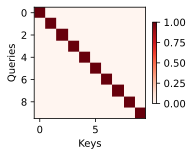

In [4]:
attention_weights = torch.eye(10).reshape((1,1,10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## Attention Pooling ```Nadaraya-Watson Kernel Regression```

- Attention pooling은 결국 Query와 Key의 상호작용의 결과이다. 
- Attention pooling은 선택적으로 입력을 취합하여 출력을 생성한다. 


In [5]:
import torch
from torch import nn
from d2l import torch as d2l



### Generating the Dataset

- 예시를 위해 y_i = 2 * sin(x_i) + x_i ** 0.8 + e의 관계를 갖는 y와 x pair의 데이터셋을 생성


In [111]:
import torch

n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
x_train

tensor([0.0194, 0.2809, 0.4111, 0.4142, 0.4257, 0.4953, 0.5752, 1.0577, 1.1621,
        1.1882, 1.2021, 1.2215, 1.2392, 1.5610, 1.5915, 1.7790, 1.8441, 1.9102,
        1.9239, 2.0882, 2.3599, 2.3607, 2.3880, 2.4001, 2.4254, 2.4608, 2.6284,
        2.6768, 2.7624, 2.9032, 3.0116, 3.1288, 3.2471, 3.2876, 3.4775, 3.5551,
        3.5635, 3.5983, 3.6780, 3.7943, 4.0166, 4.0175, 4.0524, 4.2911, 4.3708,
        4.3835, 4.5033, 4.5975, 4.7682, 4.8416])

In [112]:
def f(X: torch.Tensor):
    return 2 * torch.sin(X) + X**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, size=(n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

### Average Pooling

- "dumbest estimator"
- 단순히 y_train의 모든 값에 대한 평균
- x_i에 대한 의존성 없음 (일직선)

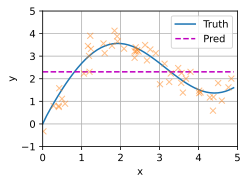

In [113]:
from d2l import torch as d2l
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], 
             xlim=[0,5], ylim=[-1,5])
    d2l.plt.plot(x_train, y_train, 'x', alpha=0.5)

y_hat =  torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

### Nonparametric Attention Pooling

- Naradaya-Watson에 의해 제안된 방식은 Value (y_i)의 weight term (attention weight)에 Key(x_i)와 Query(x)의 kernel 함수에 의해 표현되는 Naradaya-Watson kernel regression이다. 
- 모든 key-value pair에 대해 유효한 (음수가 아니며 합치면 1이 되는..) 성질의 확률 분포를 갖는 weight를 얻을 수 있음. (softmax와 유사)
- Nadaraya-Watson attention pooling은 non-parameteric attention pooling의 대표적인 케이스
- 아래 예시는 test input이 query 그리고 train input이 key로 kernel 함수를 통해 weight를 얻음


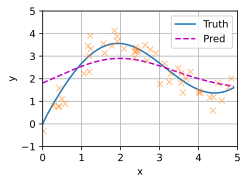

In [114]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2/2, dim=1)

y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

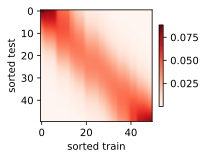

In [115]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='sorted train', ylabel='sorted test')


### Parametric Attention Pooling

- nonparametric N-W kernel regression은 일관성의 장점을 가지고 있으며 충분한 데이터가 주어지면 Optimal에 도달할 수 있지만 learnable parameter를 쉽게 적용해 볼 수 있음

#### Batch Matrix Multiplication

- 각 minibatch에 대해 attention weight를 효과적으로 계산하기 위해 batch matrx multiplication이라는 것을 활용할 수 있다.


In [116]:
X = torch.ones((2,1,4))  ## n, input
Y = torch.ones((2,4,6)) ## n, output

torch.bmm(X,Y).shape


torch.Size([2, 1, 6])

In [117]:
weights = torch.ones((2,10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
weights.unsqueeze(1).shape, values.unsqueeze(-1).shape

(torch.Size([2, 1, 10]), torch.Size([2, 10, 1]))

#### Defining Model

- bmm를 이용하여 간단한 parametric N-W kernel regression을 구현


In [118]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1 ), requires_grad=True))
        
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        print(queries.shape)
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, 
                                                       dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
    
    
        

In [119]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))

keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

epoch 10, loss 3.368518829345703


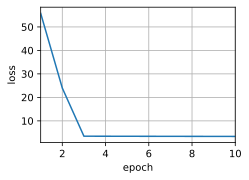

In [124]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1,10])

for epoch in range(10):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    animator.add(epoch + 1, float(l.sum()))
    print(f'epoch {epoch + 1}, loss {float(l.sum())}')

    

torch.Size([50, 50])


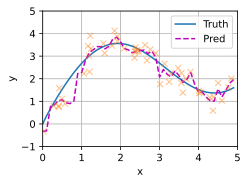

In [125]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

In [122]:
x_train, y_train, x_test

(tensor([0.0194, 0.2809, 0.4111, 0.4142, 0.4257, 0.4953, 0.5752, 1.0577, 1.1621,
         1.1882, 1.2021, 1.2215, 1.2392, 1.5610, 1.5915, 1.7790, 1.8441, 1.9102,
         1.9239, 2.0882, 2.3599, 2.3607, 2.3880, 2.4001, 2.4254, 2.4608, 2.6284,
         2.6768, 2.7624, 2.9032, 3.0116, 3.1288, 3.2471, 3.2876, 3.4775, 3.5551,
         3.5635, 3.5983, 3.6780, 3.7943, 4.0166, 4.0175, 4.0524, 4.2911, 4.3708,
         4.3835, 4.5033, 4.5975, 4.7682, 4.8416]),
 tensor([-0.3283,  0.7965,  0.8022,  0.7506,  1.5805,  1.1132,  0.8957,  2.2307,
          3.4502,  3.0118,  2.3095,  3.9024,  3.3230,  3.5604,  3.1334,  3.4623,
          4.1255,  3.8779,  3.6489,  3.3311,  2.9284,  3.2142,  3.3899,  3.2037,
          3.2722,  3.2051,  3.4925,  2.8126,  3.2955,  3.1330,  1.7591,  2.6645,
          1.8584,  2.2336,  2.4733,  1.8192,  2.2527,  1.3864,  2.0028,  2.3050,
          1.3642,  1.4720,  1.3944,  1.1703,  0.5874,  1.1894,  1.8101,  1.0322,
          1.6187,  2.0074]),
 tensor([0.0000, 0.1000, 0.20

## Attention Scoring Function

- queies와 keys로 부터 weight를 얻기 위해 사용된 gaussian kernel을 적용해 왔다. softmax로 간소화 되기 이전 즉, exponent를 제외한 부분을 attention scoring function이라 함.
- 이 attention scoring function의 결과값은 softmax를 통과하여 각 keys에 대응되는 values의 확률 분포 (혹은 attention weight)가 되며...
- attention pooling의 최종 결과는 이 attention weight에 의한 values의 weighted sum이다. 
- attention weight가 확률 분포의 형태 (즉, 합이 1이 되는...)이므로 **결과적으로 attention pooling의 결과값은 weighted average라고 볼 수 있다.**
- 다양한 attention scoring function이 있을 수 있으며 당연히도 이에 따라 다른 특성을 보인다. 
- 이어서 널리 사용되는 2가지 scoring function을 살펴 볼것임

### Masked Softmax Operation

- 앞서 masked crossentropy와 유사하게 모든 입력이 유효한 정보를 갖는 것이 아님 (<pad> 등...)
- 따라서 attention scoring function의 결과 값에 대해서도 이 유효 구간에 대해서만 적용이 되도록 할 필요가 있음
    
    
    



In [127]:
#@save 
def masked_softmax(X: torch.Tensor, valid_lens: torch.Tensor):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [129]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.5680, 0.4320, 0.0000, 0.0000],
         [0.6723, 0.3277, 0.0000, 0.0000]],

        [[0.2056, 0.4082, 0.3862, 0.0000],
         [0.3152, 0.2965, 0.3883, 0.0000]]])

### Additive Attention

- q와 k가 서로 다른 dim.을 가지고 있더라도..
- 각각을 적절히 선택된 fc를 통해 병합이 가능한 같은 dim으로 만들 수 있다.
- 이렇게 병합된 출력에 tanh의 activation을 적용하여 additive attention을 구현


In [154]:
#@save 
class AdditiveAttention(nn.Module):
    
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print(f'shape of query: {queries.shape} => {queries.unsqueeze(2).shape}' + 
              f' / shape of query: {keys.shape} => {keys.unsqueeze(1).shape}')
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        print(f'features {features.shape} / scores {scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        return torch.bmm(self.dropout(self.attention_weights), values)

In [156]:
queries, keys = torch.normal(0,1,(2,1,20)), torch.ones((2,10,2))

values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

shape of query: torch.Size([2, 1, 8]) => torch.Size([2, 1, 1, 8]) / shape of query: torch.Size([2, 10, 8]) => torch.Size([2, 1, 10, 8])
features torch.Size([2, 1, 10, 8]) / scores torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

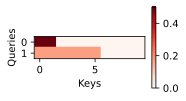

In [158]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)), xlabel='Keys', ylabel='Queries')

### Scaled Dot-Product Attention

- 연산 효율을 최적화하기 위한 한 가지 방법은 Scoring function으로 단순히 dot-product를 사용하는 것
- 단, vector의 길이가 같아야 한다는 제약이 있는데...
- 만약 두 vector (query and key)가 zero mean을 갖는 random proc.이면
- 이에 대한 dot product은 역시 zero mean을 갖는다.
- 게다가 variance를 강제로 1로 맞춰 주기 위해 scale factor인 sqrt(d)로 나눠 주게된다. 여기서 d는 vector의 size임.


In [164]:
import math
#@save
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        print(f'{scores.shape}')
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)
    

In [166]:
queries = torch.normal(0, 1, (2,1,2))
print(f'{queries.shape} {keys.shape}')
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

torch.Size([2, 1, 2]) torch.Size([2, 10, 2])
torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

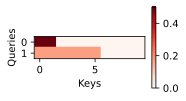

In [168]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)), xlabel='Keys', ylabel='Queries')

## Bahdanau Attention

- seq to seq 구조에서 deocder는 fixed size의 context varaible을 decider는 이 context variable과 생성된 token에 의해 한 token 씩 결과를 생성해 내는데...
- 입력 token 들 중 일부는 매우 낮은 중요도를 가지고 있는데, 
- 실제 사용되는 context variable은 이 모든 입력을 축약한 값을 모든 decode step에 동일하게 사용하게된다.
- 약간 다르지만 연관된 맥락에서 텍스트를 수기로 변환하는 문제에서 Graves는 text seq.와 pen trace seq를 align 하기 위해서 attention model을 사용했다. 
- 이러한 Idea에 착안하여 Bahdanau 등은  alignment 제약이 없는 미분가능한 attention model을 고안하였다. 
- 이를 통해 token을 생성(예측)할 때 모든 입력 토큰을 사용하는 것이 아닌 현재 생성과 연관된 토큰만을 사용하는 attention model
  - encoder의 context variable을 attention pooling의 output을 사용함으로써 구현하였다.

### Model

- additive attention scoring function을 사용
- t-1의 decoder hidden state를 keys로 t의 endcoder의 hidden state를 queries로 위 scoring function에 계산

In [169]:
import torch
from torch import nn
from d2l import torch as d2l



### Decoder with Attention

- Bahdanau attention의 RNN encoder-decoder에서 decoder만 바뀌게 됨.



In [170]:
#@save 
class AttentionDecoder(d2l.Decoder):
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attention_weights(self):
        raise NotImplementedError
        

- Decode의 상태는 아래 3가지로 초기화 된다.
  - final layer의 all steps의 hidden state => attention의 keys and values로...
  - all layer의 final steps의 hidden state 
  - encoder valid length 
  - attention의 output이 context이며 이 context와 x를 concat하여 RNN에 입력
  - decoder의 이전 step의 hidden state => query로...

In [172]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, 
                                     enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights
    
            
        

In [174]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()

X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape


(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 7787.4 tokens/sec on cuda:0


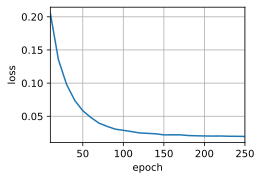

In [175]:
embed_size, num_hiddens, num_layers, dropout = 32,32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [176]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, 
                                                                eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000
